## 背景
我为什么要专门讨论一下问题？因为我在mario项目中遇到了瓶颈，我改变了常规的对于mario一帧一帧的选择单个动作的环境，修改为让agent选择多个动作的执行时间，输入到环境中，
让我感觉类似人的处理过程，并且我修改了奖励函数，增加了环境的信息。问题本质由离散变为连续，所以我尝试了PPO，SAC，TD3，其中加了很多在mujoco上认可的优化，做了很多的实验，但是实验结果显示，所有的算法都没法稳定的收敛，PPO可以到达一个较好的水平，而所有算法训练下的agent都能试出一个很高的峰值，但是，都没法保留这个峰值，所以我觉得可能是问题的定义不太清楚，也确实有很多模糊的地方，我决定重新开始，全部搞清楚。


In [1]:
# 离散的处理
from preENV.discret import ProcessEnv
import gym_super_mario_bros
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [38]:
# 不对图片进行处理
env_name: str = "SuperMarioBros-1-1-v0"
env = gym_super_mario_bros.make(env_name,render_mode='human', apply_api_compatibility=True)

state = env.reset()
state = state[0]
a = np.copy(state)
next_states = []
next_states.append(a)
i = 0
while(True):
    
    action = env.action_space.sample()
    
    next_state,reward,done,_,_ = env.step(action)
    if i<10:
        i += 1
        next_states.append(np.copy(next_state))
    
    if done:
        env.close()
        break

d:\anaconda3\envs\torch_rl\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
d:\anaconda3\envs\torch_rl\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
d:\anaconda3\envs\torch_rl\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
d:\anaconda3\envs\torch_rl\lib\site-packages\gym\utils\passive_env_checker.py:237: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(truncated, (bool, np.bool8)):


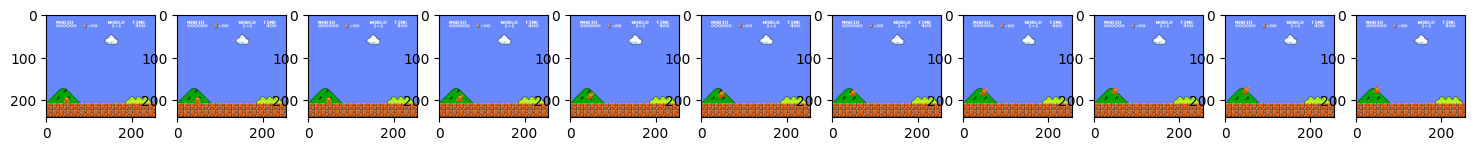

In [39]:
aa = np.array(next_states)

plt.figure(figsize=(20,16))
for idx in range(aa.shape[0]):
    plt.subplot(1,aa.shape[0]+1,idx+1)
    plt.imshow(aa[idx])
plt.show()

In [27]:
# 离散的处理

env_name: str = "SuperMarioBros-1-1-v0"
env = gym_super_mario_bros.make(env_name,render_mode='human', apply_api_compatibility=True)

env = ProcessEnv(env)
state = env.reset()
state = state[0]
i = 0
ns = []
actions = []

while(True):
    
    action = env.action_space.sample()
    
    next_state,reward,done,_,_ = env.step(action)
    i += 1
    if i>30 and i<=40:
        ns.append(np.copy(next_state))
        actions.append(action)
    if done:
        env.close()
        break



d:\anaconda3\envs\torch_rl\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
d:\anaconda3\envs\torch_rl\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
d:\anaconda3\envs\torch_rl\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
d:\anaconda3\envs\torch_rl\lib\site-packages\gym\utils\passive_env_checker.py:237: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(truncated, (bool, np.bool8)):
d:\anaconda3\envs\torch_rl\lib\site-packages\gym\utils\passive_env_checker.py:272: UserWarning: WARN: No re

In [28]:
SIMPLE_MOVEMENT = [
    ['NOOP'],
    ['right'],
    ['right', 'A'],
    ['right', 'B'],
    ['right', 'A', 'B'],
    ['A'],
    ['left'],
]

actions

[array([ 0, -1,  0,  1,  1,  0,  1], dtype=int64),
 array([ 0,  0,  1,  1, -1, -1,  1], dtype=int64),
 array([-1, -1, -1,  0,  0,  1,  1], dtype=int64),
 array([ 1,  0,  0,  1, -1,  0,  0], dtype=int64),
 array([-1, -1, -1,  1,  1,  0,  1], dtype=int64),
 array([-1,  1,  1,  1, -1,  1, -1], dtype=int64),
 array([-1, -1,  0,  0,  1,  0,  1], dtype=int64),
 array([ 0,  1,  1,  0,  0, -1,  0], dtype=int64),
 array([-1, -1,  1, -1,  1,  0,  1], dtype=int64),
 array([ 0,  0, -1, -1,  1, -1,  1], dtype=int64)]

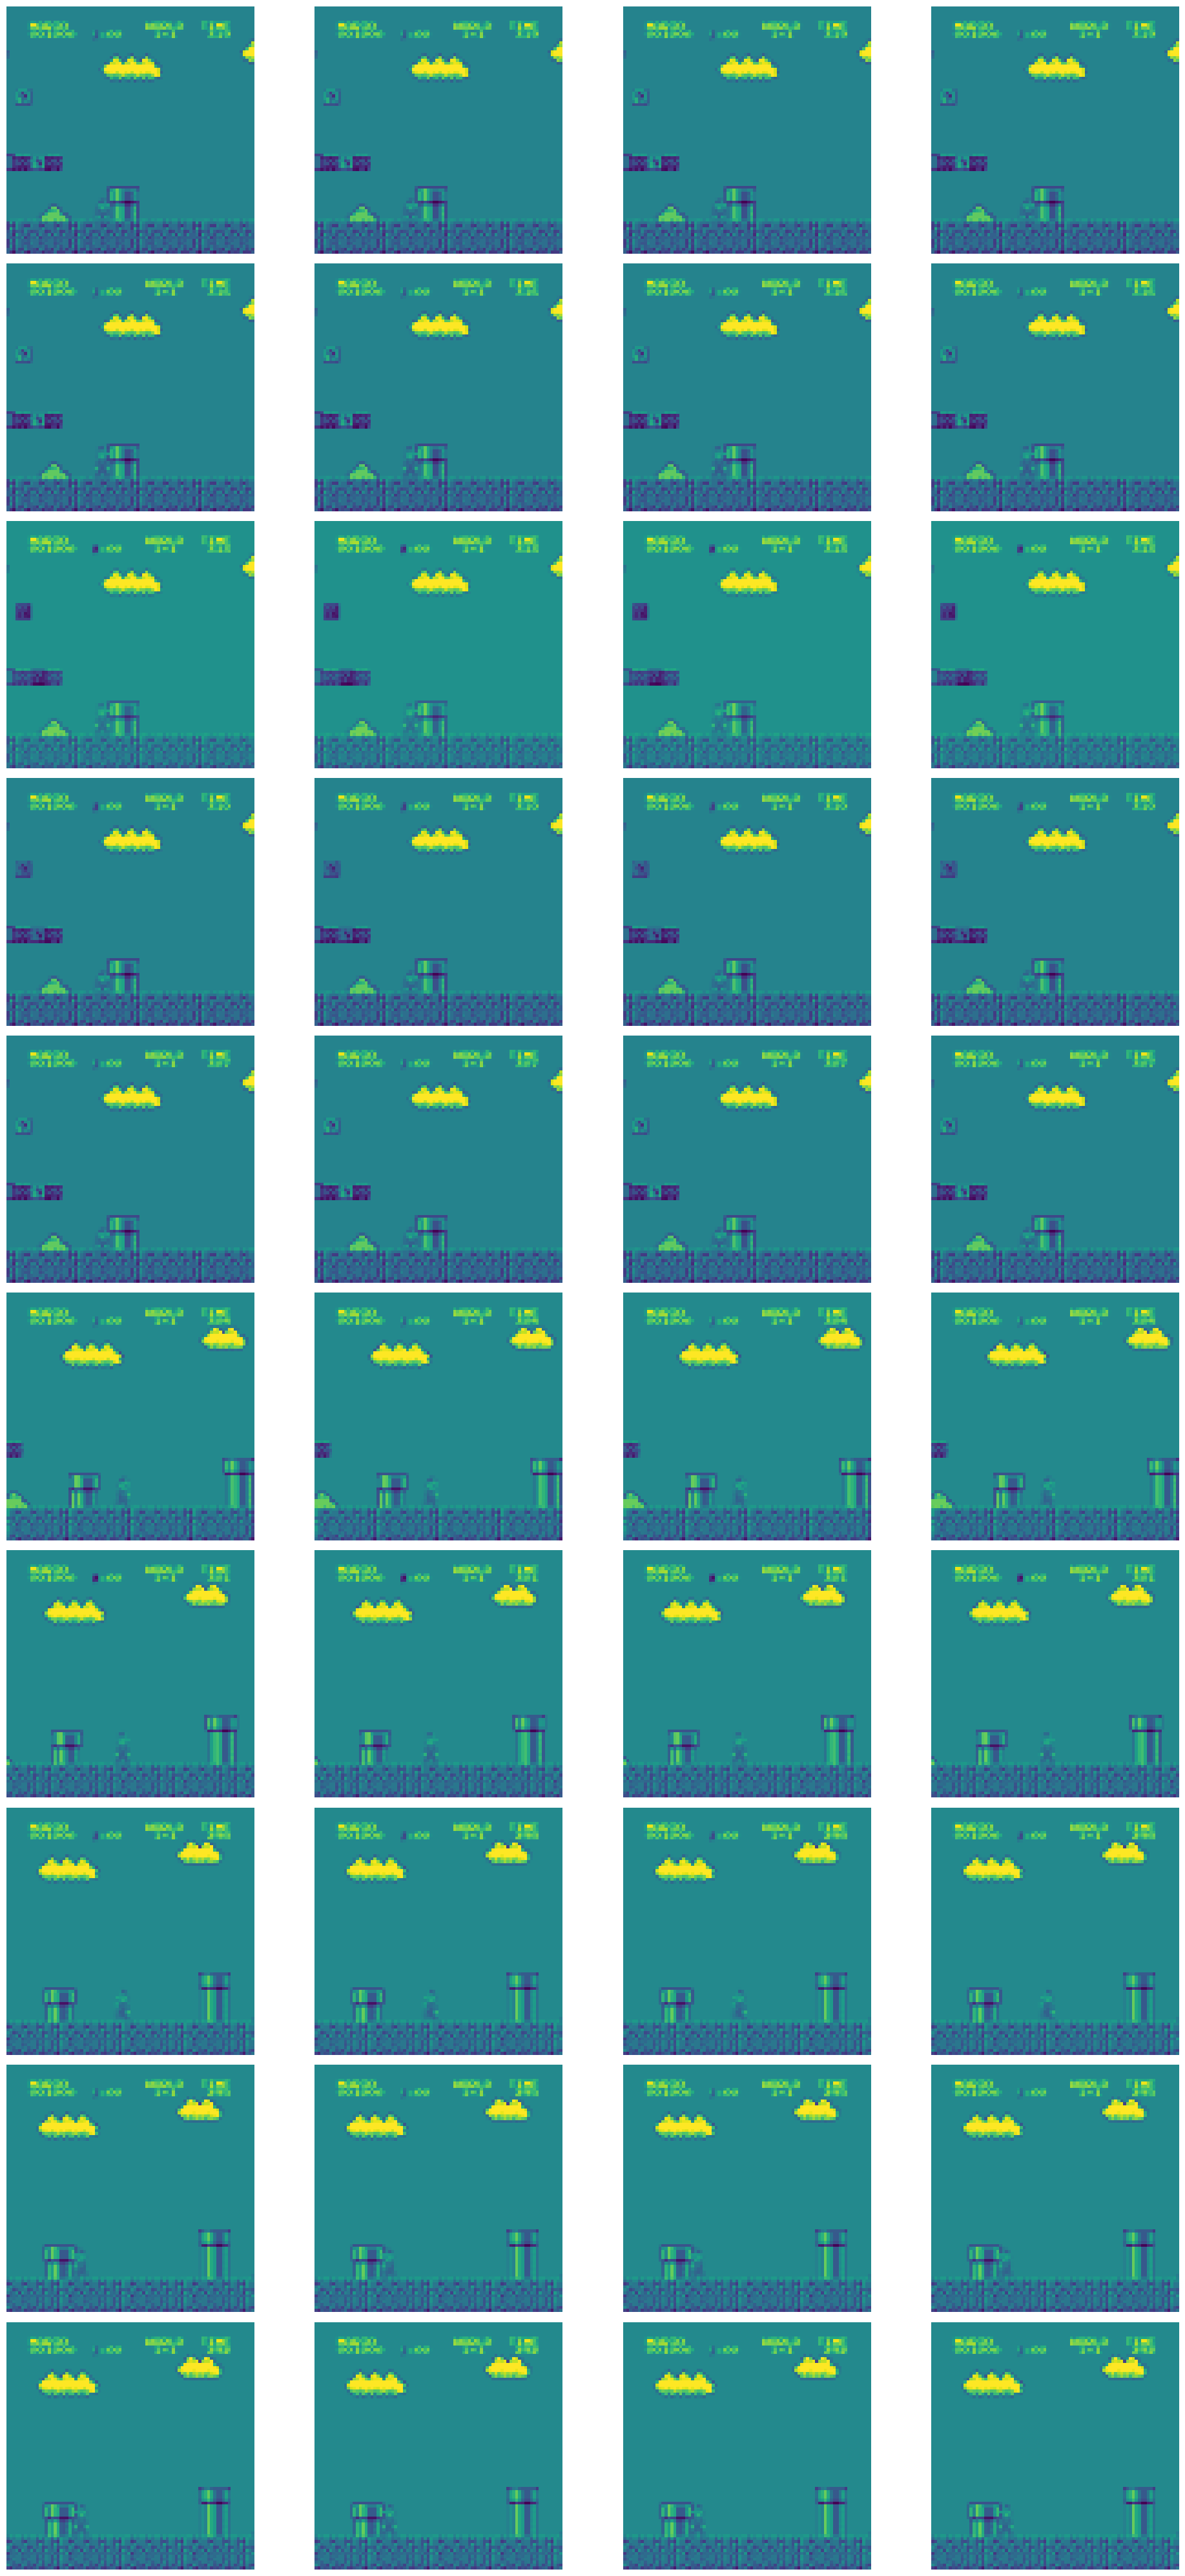

In [29]:
ns = np.array(ns)
num_images = ns.shape[0] * ns.shape[1]  # 总共的图像数量
images_per_row = 4  # 每排显示的图像数量

num_rows = int(np.ceil(num_images / images_per_row))  # 计算所需的行数

plt.figure(figsize=(20, 4 * num_rows))  # 动态调整高度以适应行数

for idx in range(num_images):
    row = idx // images_per_row
    col = idx % images_per_row
    plt.subplot(num_rows, images_per_row, idx + 1)
    plt.imshow(ns[idx // ns.shape[1], idx % ns.shape[1]])  # 调整图像索引
    plt.axis('off')  # 隐藏坐标轴

plt.tight_layout()  # 自动调整子图间距
plt.show()

## 如果是离散问题
离散的环境，找到最优路径的可能性更大，因为每一帧执行一个动作，但是相应的，探索强度就会变弱，因为解空间太大了，定位到每一帧。
即使经过离散环境的处理，每个动作延续4帧，并且堆叠4帧，在此之前每一帧会变成[84,84]的灰度图像。
堆叠的原理是：在一开始复制4帧的初始状态[0,0,0,0]，放入队列，从执行第一个动作，延续4帧，此时记录最后一帧，放入队列，[0,0,0,1]，执行第二个动作[0,0,1,2]，在延续到最后
[n-2,n-1,n,n+1]，这里存储的每一帧，都是一个动作执行4帧的末尾帧，总共4帧，4个动作的结果。

In [2]:
## 连续处理
from preENV.continues import ProcessEnv

env_name: str = "SuperMarioBros-1-1-v0"
env = gym_super_mario_bros.make(env_name,render_mode='human', apply_api_compatibility=True)

env = ProcessEnv(env)
state = env.reset()
state = state[0]
action_dim = env.action_space.shape[0]
i = 0
ns = []
actions = []
while(True):
    action = 2 * np.random.rand(action_dim) - 1 
    next_state,reward,done,_,_ = env.step(action)
    i += 1
    if i>20 and i<=30:
        ns.append(np.copy(next_state))
        actions.append(action)
    if done:
        env.close()
        break

d:\anaconda3\envs\torch_rl\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
d:\anaconda3\envs\torch_rl\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
d:\anaconda3\envs\torch_rl\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
d:\anaconda3\envs\torch_rl\lib\site-packages\gym\utils\passive_env_checker.py:237: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(truncated, (bool, np.bool8)):
d:\anaconda3\envs\torch_rl\lib\site-packages\gym\utils\passive_env_checker.py:272: UserWarning: WARN: No re

In [3]:
MYACTION = [
    ['NOOP'],
    ['right'],
    ['left'],
    ['down'],
    ['up'],
    ['A'],
    ['B']
]
actions

[array([-0.10590602,  0.18176629, -0.24884974, -0.34470231, -0.16661557,
        -0.25360046, -0.20296628]),
 array([-0.19590561, -0.81632137,  0.9390966 ,  0.07716464,  0.58820348,
        -0.51623983,  0.39942586]),
 array([ 0.32174378, -0.95177499, -0.1993071 ,  0.82349542,  0.77167829,
         0.82291353,  0.17431686]),
 array([ 0.22323934,  0.38118816,  0.34421317, -0.26861103,  0.48217565,
         0.93273407,  0.09208039]),
 array([ 0.75739865,  0.94629866,  0.58734785,  0.51162504, -0.0841429 ,
         0.94936998, -0.17739572]),
 array([-0.90795721, -0.90301946,  0.21171352, -0.92225649,  0.91351053,
        -0.35435353,  0.93530917]),
 array([-0.32380905,  0.31815219, -0.86237188, -0.12605547, -0.76047569,
        -0.78659309, -0.92944829]),
 array([ 0.92278117,  0.04122587, -0.14980582, -0.17398466, -0.50295278,
        -0.86310843, -0.69753864]),
 array([ 0.93194266,  0.56074769, -0.47602476,  0.3612636 ,  0.01115879,
         0.78225536, -0.26735236]),
 array([ 0.90918721

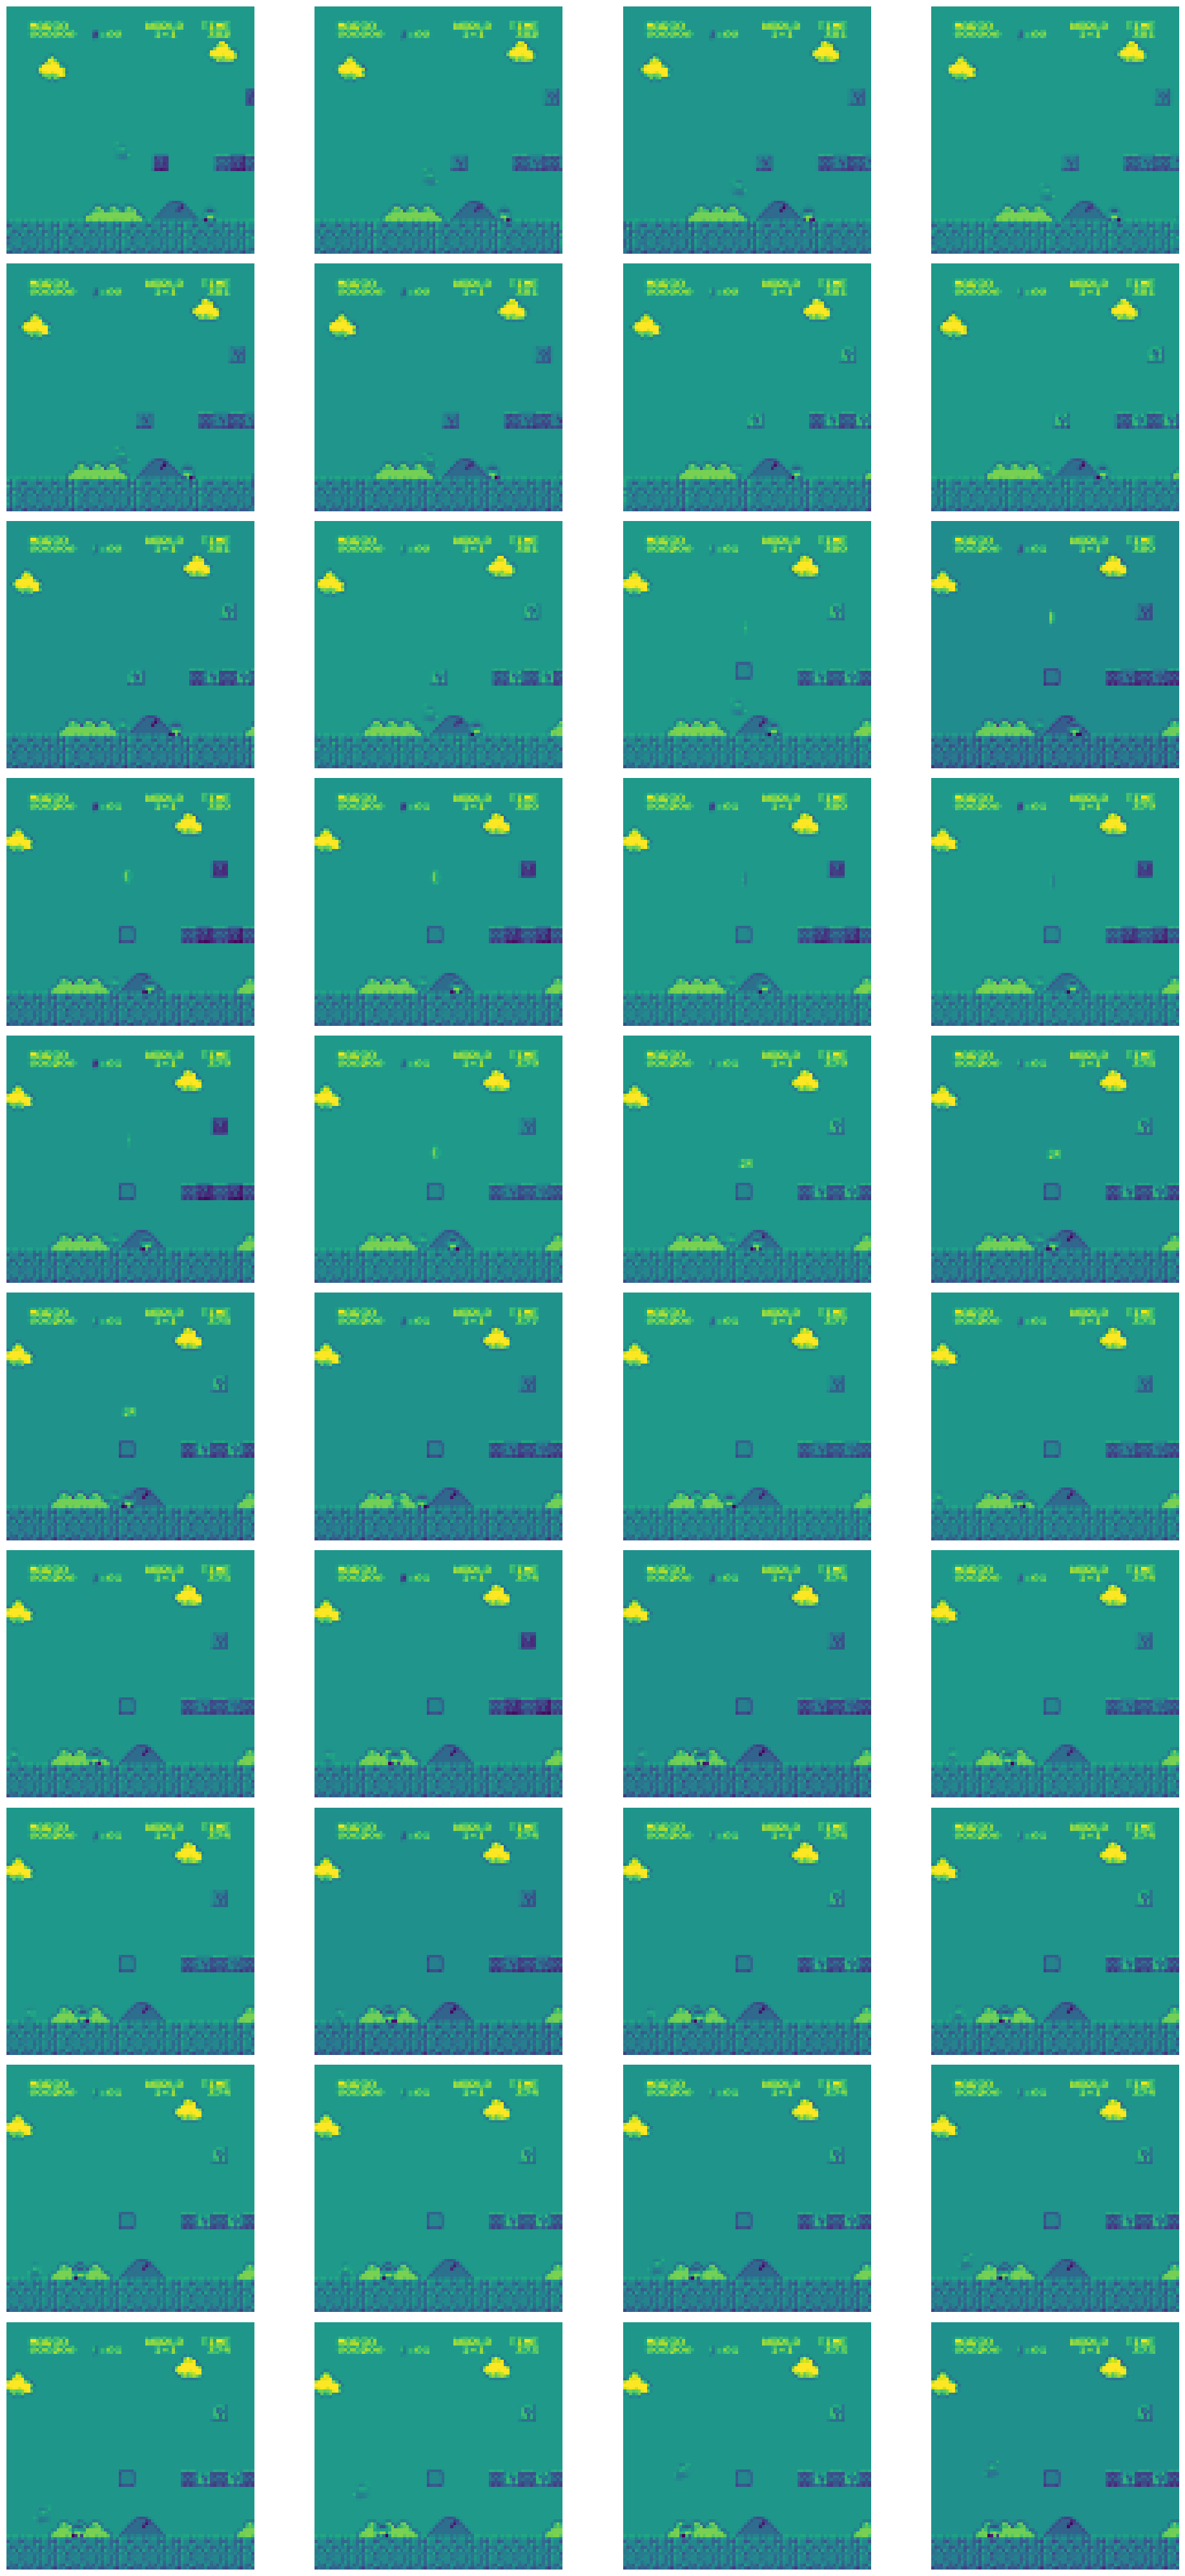

In [4]:
ns = np.array(ns)
num_images = ns.shape[0] * ns.shape[1]  # 总共的图像数量
images_per_row = 4  # 每排显示的图像数量

num_rows = int(np.ceil(num_images / images_per_row))  # 计算所需的行数

plt.figure(figsize=(20, 4 * num_rows))  # 动态调整高度以适应行数

for idx in range(num_images):
    row = idx // images_per_row
    col = idx % images_per_row
    plt.subplot(num_rows, images_per_row, idx + 1)
    plt.imshow(ns[idx // ns.shape[1], idx % ns.shape[1]])  # 调整图像索引
    plt.axis('off')  # 隐藏坐标轴

plt.tight_layout()  # 自动调整子图间距
plt.show()

## 连续动作的处理

这里必须提一下，我之前处理代码写错了，没有像我脑子里面想的截取执行某个动作中的几帧，变成了全部是最后一帧，
obs.all.apend(obs)  ->  obs.all.apend(np.copy(obs))  
我不知道这样影响会多大，但是确实没有按照我想的来。后面我会改下再做实验，至少再做错了的情况下，全部不行。

连续动作，我是这么想的：
对于图片的处理还是和离散动作一样，灰度图片，[84,84]。而对于每个动作的执行，它可能延续几十帧，我选择开头和结尾，中间随机选择几帧，当作
下一个状态。而在动作范围的选择上，每个值代表时间s，进入环境时，会x*60，代表多少帧，[-1,1],代表动作可以有存量，就像加速度一样，有加有减；[0,1]，就代表只能规划，规划了做什么动作，执行多久，一直持续到规划结束。

而对于状态，虽然传入的是图片，但是经过分类器MLP的是一串由CNN提取特征之后的向量，而对于连续动作环境mujoco，一开始就是一串向量，会带来什么差别？


此时变成连续的动作后，就想到可以用PPO，SAC，TD3连续的版本，但此时遇到一个问题，动作之间时独立执行的吗？有的是(比如左右，上下)，有的不是(左右上下+AB)，此时当碰到了选择，我应该看看前辈们，或者说游戏界里面怎么看输入指令，对应的输出，对于游戏界是怎样处理的，对于RL界是怎么处理的？  

调研列表：
RL：openaiFive，alphaStar，腾讯王者荣耀，mujoco，atari
游戏界：格斗游戏，LOL